# Gaussian Process on the Power Plant UCI dataset, using Inducing Points and all points

# Github

In [1]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Project18/GPs


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
from sklearn.model_selection import train_test_split
import math
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/powerPlant.ipynb # Run the PowerPlant notebook which is in the datasets folder(PowerPlant dataset)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 19.5 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/datasets
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None

AT    False
V     False
AP    False
RH    False
PE    False
dtype: bool


# Training/Test data from concrete.ipynb

In [9]:
# Set a seed for reproducibility
np.random.seed(52)

powerPlant_data = df_PowerPlant # df_PowerPlant is defined in ../datasets/powerPlant.ipynb
x, y = powerPlant_data.iloc[:, :-1].to_numpy() , powerPlant_data.iloc[:, -1].to_numpy()  # The last column is output(net hourly electrical energy output (EP)  of the plant)

# Split into training and validation datasets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1)

# Convert them to tensors
xTrain = torch.from_numpy(xTrain).float()
yTrain = torch.from_numpy(yTrain).float()

xTest = torch.from_numpy(xTest).float()
yTest = torch.from_numpy(yTest).float()

print(xTrain.size(), yTrain.size(), xTest.size(), yTest.size())

torch.Size([8611, 4]) torch.Size([8611]) torch.Size([957, 4]) torch.Size([957])


# The GP model

In [10]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x, y, likelihood):
        super(GPModel, self).__init__(x, y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [11]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(xTrain, yTrain, likelihood) # Use training points and given likelihood
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Training Function

In [12]:
import os
def train(model, xTrain, yTrain): # Train the model on training data: xTrain, yTrain

  smoke_test = ('CI' in os.environ)
  training_iter = 2 if smoke_test else 100


  # Find optimal model hyperparameters
  model.train()
  model.likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  # Train without printing to ensure the training method is as fast as possible
  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(xTrain)
      # Calc loss and backprop gradients
      loss = -mll(output, yTrain)
      loss.backward()
      optimizer.step()


# Train the Model#

In [13]:
%time train(model, xTrain, yTrain) # 1h12min for 250 training iterations

CPU times: user 23min 25s, sys: 2min 2s, total: 25min 27s
Wall time: 25min 42s


# The posterior mean, variance and Covariance Matrix

In [14]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
  model.eval() # eval mode is for computing predictions through the model posterior
  f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
  f_mean = f_preds.mean # Predictive mean
  f_var = f_preds.variance # Predictive variance
  f_covar = f_preds.covariance_matrix # Covariance matrix
  print("Mean Dimension: ", f_mean.size())
  print()
  print("Variance Dimension: ", f_var.size())
  print()
  print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([957])

Variance Dimension:  torch.Size([957])

CovMatrix Dimension  torch.Size([957, 957])


# Predictive Distribution

In [15]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(f_preds)# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    mean = observed_pred.mean.numpy()

# Compute Root Mean Square Error (RMSE)

In [16]:
yTest = yTest.numpy() # Convert to numpy

squared_error = (mean - yTest)**2 # Compute the squared error

mean_SE = squared_error.mean() # Compute the mean squared error

root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error

root_MSE

31.291390557897472

# Check for Overfitting, (RMSE of training data)

In [17]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred_train = likelihood(model(xTrain))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    mean_train = observed_pred_train.mean.numpy()

yTrain_Numpy = yTrain.numpy() # Convert to numpy
squared_error_train = (mean_train - yTrain_Numpy)**2 # Compute the squared error

mean_SE_train = squared_error_train.mean() # Compute the mean squared error

root_MSE_train = math.sqrt(mean_SE_train) # Compute the square root of the mean squared error

root_MSE_train

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


21.303179808908883

# Compare different amount of points

In [18]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPoints(listOfPoints):
  timeList = []
  maxPoints = len(xTrain) # The max amount of points in training points
  for points in listOfPoints:
    inducingPointsX = torch.tensor(x[:points]) # Choose how many points to pick
    inducingPointsY = torch.tensor(y[:points]) # Choose how many points to pick

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    print()
    print("Inducing Points: ", points)

    time = %timeit -o train(model, inducingPointsX, inducingPointsY) # Train the model
    timeList.append(time.all_runs) # Add mean time of all runs for current amount of points
    # Plot
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()
  return timeList
timeList = severalInducingPoints([100,200,300,400,500,600,700,800,900,1000])



Inducing Points:  100
456 ms ± 74.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  200
867 ms ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  300
1.33 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  400
2.58 s ± 435 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  500
4.35 s ± 586 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  600
6.51 s ± 846 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  700
9.55 s ± 889 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  800
13.3 s ± 684 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  900
5.79 s ± 496 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  1000
6.76 s ± 728 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Plot The Different Times

([<matplotlib.axis.XTick at 0x7ffaba921390>,
 [Text(1, 0, '100'),
  Text(2, 0, '200'),
  Text(3, 0, '300'),
  Text(4, 0, '400'),
  Text(5, 0, '500'),
  Text(6, 0, '600'),
  Text(7, 0, '700'),
  Text(8, 0, '800'),
  Text(9, 0, '900'),
  Text(10, 0, '1000')])

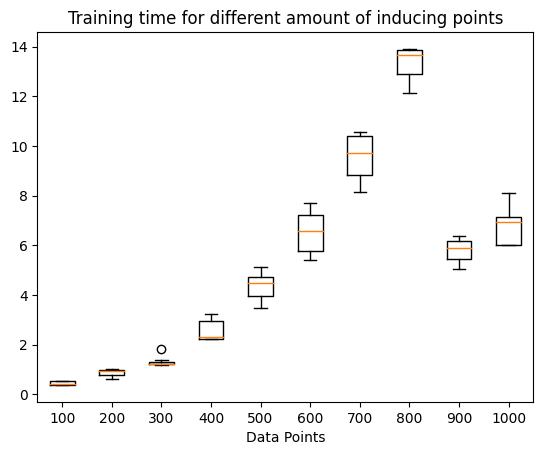

In [20]:
plt.title('Training time for different amount of inducing points')
plt.xlabel('Data Points')

plt.boxplot(timeList)
plt.xticks([1,2,3,4,5,6,7,8,9,10],[100,200,300,400,500,600,700,800,900,1000])

# Inducing Points with K-means

#K-means

In [7]:
def kmeansPoints(x, y, N): # The dataset (X,Y) and the N amount of inducing points wished
  # Normalize training points
  x_mean = x.mean(axis = 0) # mean for each feature
  x_std = x.std(axis = 0) # std for each feature
  x_normalized = (x-x_mean) / x_std # Normalize
  RS = 0 # Random state
  kmeans = KMeans(n_clusters=N, n_init=1, random_state=RS ).fit(x_normalized) # Apply K-means clustering on the normalized training data
  xInducing = kmeans.cluster_centers_ # Use the centers of the clusters as the inducing points
  # To get the corresponding y values for each inducing point, compute the closest data point.
  closest_indices, _ = pairwise_distances_argmin_min(xInducing, x_normalized) # Will return indexes of xTrain_KMeans which is most similar(the same in this case) as xInducing
  yInducing = y[closest_indices] # Choose the corresponding y values for the inducing points
  xInducing = x[closest_indices] # We want to return the non-normalized x
  return xInducing, yInducing

# Compare different amounts of inducing points
## Speed and Performance

In [8]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPointsKmeans(listOfPoints):
  maxPoints = len(xTrain) # The max amount of points in training points
  for points in listOfPoints:
    print()
    print("Inducing Points: ", points)
    print("K-means:")
    inducingPointsX, inducingPointsY = %time kmeansPoints(xTrain, yTrain, points) # Choose how many points to pick
    inducingPointsX = inducingPointsX.float()
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    print("Training:")

    %time train(model, inducingPointsX, inducingPointsY) # Train the model
    # Performance
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
      print("Predicitve Distribution:")
      observed_pred = %time likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
      mean = observed_pred.mean.numpy()

    squared_error = (mean - yTest.numpy())**2 # Compute the squared error
    mean_SE = squared_error.mean() # Compute the mean squared error
    root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error
    print("RMSE: ", root_MSE)


severalInducingPointsKmeans([5,10,100,200,300,400,500,600,700,900])


Inducing Points:  5
K-means:
CPU times: user 58.8 ms, sys: 92.8 ms, total: 152 ms
Wall time: 126 ms
Training:
CPU times: user 957 ms, sys: 111 ms, total: 1.07 s
Wall time: 1.43 s
Predicitve Distribution:
CPU times: user 6.31 ms, sys: 29 µs, total: 6.34 ms
Wall time: 12.7 ms
RMSE:  447.75706652715155

Inducing Points:  10
K-means:
CPU times: user 64.8 ms, sys: 49.5 ms, total: 114 ms
Wall time: 62.3 ms
Training:
CPU times: user 325 ms, sys: 50.9 ms, total: 376 ms
Wall time: 320 ms
Predicitve Distribution:
CPU times: user 6.05 ms, sys: 200 µs, total: 6.25 ms
Wall time: 6.17 ms
RMSE:  447.5686399872091

Inducing Points:  100
K-means:
CPU times: user 226 ms, sys: 112 ms, total: 338 ms
Wall time: 223 ms
Training:
CPU times: user 426 ms, sys: 2.22 ms, total: 428 ms
Wall time: 445 ms
Predicitve Distribution:
CPU times: user 6.24 ms, sys: 2 µs, total: 6.25 ms
Wall time: 6.24 ms
RMSE:  74.66719127652385

Inducing Points:  200
K-means:
CPU times: user 401 ms, sys: 91.2 ms, total: 492 ms
Wall tim

In [29]:
!git add commit -m ""